# Gene essentiality

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas import DataFrame
from cameo import load_model, fba
from cameo.util import TimeMachine
from cameo import exceptions
model = load_model('data/e_coli_core.xml.gz')

## Knocking out a single gene

In the model, exactly one gene is associated with reaction with [phosphoglycerate kinase](http://bigg.ucsd.edu/universal/reactions/PGK) (PGK).

In [2]:
model.reactions.PGK.genes

frozenset({<Gene b2926 at 0x119241f28>})

Checking the name of this gene in the model (the id is the Blattner number b2926), reveals that it is indeed [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703).

In [3]:
model.genes.b2926.name

'pgk'

Is [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703) essential? Let's find out.

In [4]:
pgk_mutant = model.copy()
pgk_mutant.genes.b2926.knock_out()
pgk_mutant.solve().objective_value

0.0

Yes, it is.

## Perform all possible single gene deletions

Using a `for` loop allows to iterate over all genes in the model and knock out each one of them individually. We're using `TimeMachine` to undo every gene deletion before proceeding to the next knockout.

In [5]:
essentiality = {}
for gene in model.genes:
    with TimeMachine() as tm:
        gene.knock_out(time_machine=tm)
        try:
            solution = model.solve()
        except exceptions.Infeasible:
            solution
        else:
            essentiality[gene] = solution.objective_value

In [6]:
df = DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')

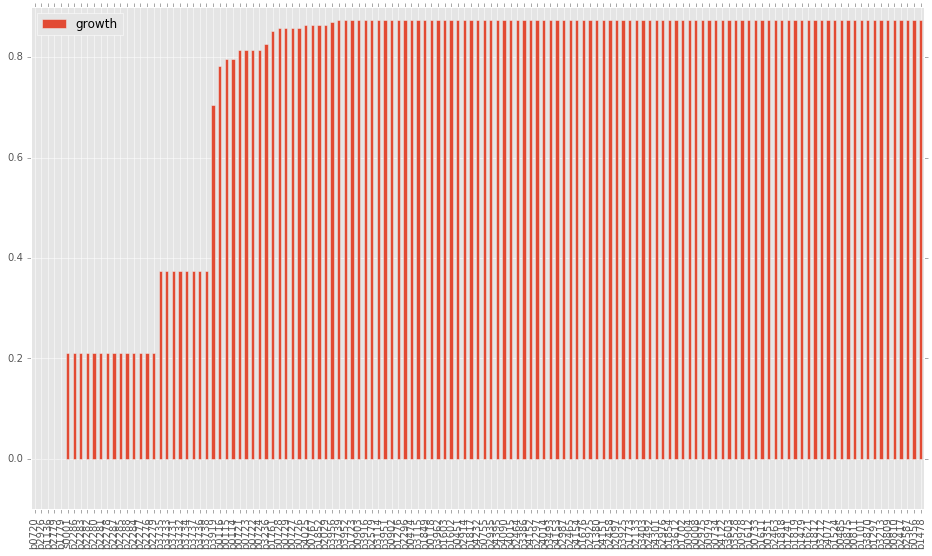

In [7]:
ax = df.plot.bar().axes
ax.figure.set_size_inches(16, 9)

## Exercises

1. How many genes are in each category (essential and non-essential)? How many non-essential genes show a reduced growth rate?
2. Determine the essentialiy of genes for all other available carbon sources (if this is too complicated, determine the essentiality profile for one other carbon source).

Hints:
* Sometimes an optimal solution cannot be found for certain knockouts (an exception is raised). Use `try` and `except` to catch infeasible solutions.

### Solution 1

In [8]:
wt_growth_rate = model.solve().objective_value
essential = 0
reduced_growth = 0
same_growth = 0
for gene, growth in essentiality.items():
    if growth < 0.05:
        essential = essential + 1
    elif growth > wt_growth_rate * .95:
        same_growth = same_growth + 1
    else:
        reduced_growth = reduced_growth + 1

In [9]:
essential

5

In [10]:
reduced_growth

31

In [11]:
same_growth

99

### Solution 2

In [12]:
carbon_exchanges = ['EX_ac_e', 'EX_etoh_e', 'EX_for_e',
                    'EX_fru_e', 'EX_fum_e', 'EX_glc__D_e', 'EX_glc__D_e',
                    'EX_lac__D_e', 'EX_mal__L_e', 'EX_pyr_e', 'EX_succ_e']

In [13]:
result = {}
with TimeMachine() as tm:
    model.reactions.EX_glc__D_e.change_bounds(0, 0, time_machine=tm)
    for source in carbon_exchanges:
        print('Determining essentiality for: ' + source)
        result[source] = {}
        model.reactions.get_by_id(source).change_bounds(-20, 0, time_machine=tm)
        for gene in model.genes:
            with TimeMachine() as tm2:
                gene.knock_out(time_machine=tm2)
                try:
                    solution = model.solve()
                except exceptions.Infeasible:
                    result[source][gene] = 0.
                else:
                    result[source][gene] = solution.objective_value

Determining essentiality for: EX_ac_e
Determining essentiality for: EX_etoh_e
Determining essentiality for: EX_for_e
Determining essentiality for: EX_fru_e
Determining essentiality for: EX_fum_e
Determining essentiality for: EX_glc__D_e
Determining essentiality for: EX_glc__D_e
Determining essentiality for: EX_lac__D_e
Determining essentiality for: EX_mal__L_e
Determining essentiality for: EX_pyr_e
Determining essentiality for: EX_succ_e


In [14]:
from pandas import DataFrame

In [15]:
df = DataFrame.from_dict(result)

In [16]:
import matplotlib.pyplot as plt

In [17]:
binary_df = df.applymap(lambda x: 0 if x < 0.05 else 1)

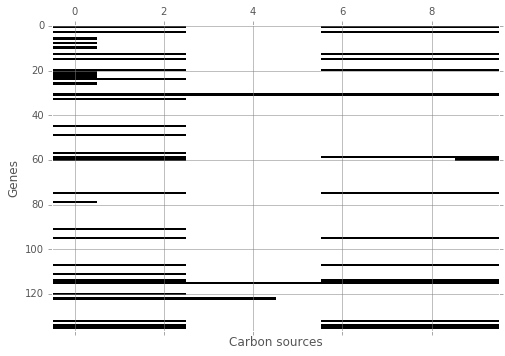

In [18]:
ax = plt.matshow(binary_df, cmap='gray').axes
ax.set_aspect(.05)
ax.grid(color='gray')
ax.set_xlabel('Carbon sources')
ax.set_ylabel('Genes')
ax.figure.set_figwidth(8)

## Gene essentiality with respect to each biomass precursor

In [19]:
biomass_precursors = model.reactions.BIOMASS_Ecoli_core_w_GAM.reactants
len(biomass_precursors)

16

In [20]:
model_copy = model.copy()
precursor_essentiality = {}
for precursor in biomass_precursors:
    print('Determining essentiality profile for precursor: ' + precursor.id)
    precursor_essentiality[precursor.name] = {}
    demand = model_copy.add_exchange(precursor)
    model_copy.objective = demand
    for gene in model_copy.genes:
        with TimeMachine() as tm:
            gene.knock_out(time_machine=tm)
            try:
                solution = model_copy.solve()
            except:
                precursor_essentiality[precursor.name][gene.name] = 0
            else:
                precursor_essentiality[precursor.name][gene.name] = solution.objective_value

Determining essentiality profile for precursor: pep_c
Determining essentiality profile for precursor: h2o_c
Determining essentiality profile for precursor: g3p_c
Determining essentiality profile for precursor: f6p_c
Determining essentiality profile for precursor: e4p_c
Determining essentiality profile for precursor: gln__L_c
Determining essentiality profile for precursor: pyr_c
Determining essentiality profile for precursor: nadph_c
Determining essentiality profile for precursor: nad_c
Determining essentiality profile for precursor: g6p_c
Determining essentiality profile for precursor: atp_c
Determining essentiality profile for precursor: 3pg_c
Determining essentiality profile for precursor: accoa_c
Determining essentiality profile for precursor: oaa_c
Determining essentiality profile for precursor: glu__L_c
Determining essentiality profile for precursor: r5p_c


In [21]:
df = DataFrame.from_dict(precursor_essentiality)
df = df.applymap(lambda x: 0 if x < 0.05 else 1)

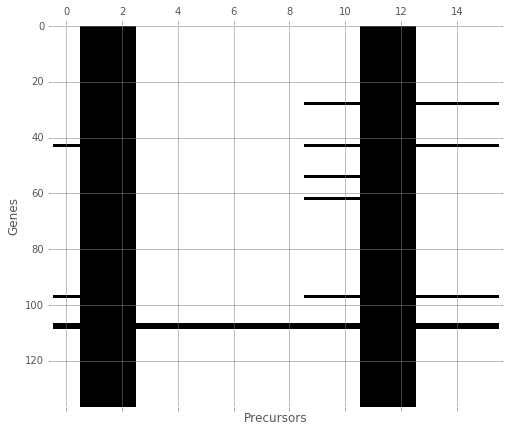

In [22]:
from matplotlib import pyplot as plt
from matplotlib import colorbar
x = plt.matshow(df, cmap='gray')
ax = x.axes
ax.grid(color='gray')
# plt.colorbar(mappable=x, ax=ax)
ax.figure.set_figwidth(8)
ax.set_aspect(.1)
ax.set_xlabel('Precursors')
ax.set_ylabel('Genes')
plt.show()